In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


## Import libs

In [3]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import shutil

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

## Config setting

In [ ]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256] 
		# self.anchor_box_scales = [32, 64, 128] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
		# self.anchor_box_ratios = [[1, 1], [1, 1.2], [1, 0.8]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 500

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

## Parser the data from annotation file

In [ ]:


def get_data(input_path):
	"""Parse the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True

	i = 1
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:

			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

## Define ROI Pooling Convolutional Layer

In [ ]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        # self.dim_ordering = K.image_dim_ordering() # changed
        # self.dim_ordering = K.common.image_dim_ordering()
        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            # rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size)) changed
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Vgg-16 model

In [ ]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

## RPN layer

In [ ]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

## Classifier layer

In [ ]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 8):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

## Calculate IoU (Intersection of Union)

In [ ]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

## Calculate the rpn for all anchors of all images

In [ ]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

## Get new image size and augment the image

In [ ]:
def get_new_img_size(width, height, img_min_side=500):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

## Generate the ground_truth anchors

In [ ]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32) 
				# changed
				# x_img = x_img.astype(np.in64)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

## Define loss functions for all four outputs

In [ ]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [ ]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [ ]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [ ]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

## --------------------------------------

In [ ]:
base_path = '/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/'

# test_path = 'drive/MyDrive/traffic_train/PREPROCESSED/test_annotation.txt'

test_base_path = '/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/data/test' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [ ]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

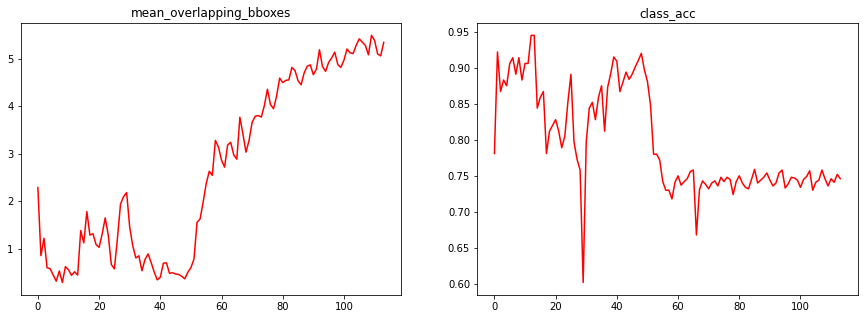

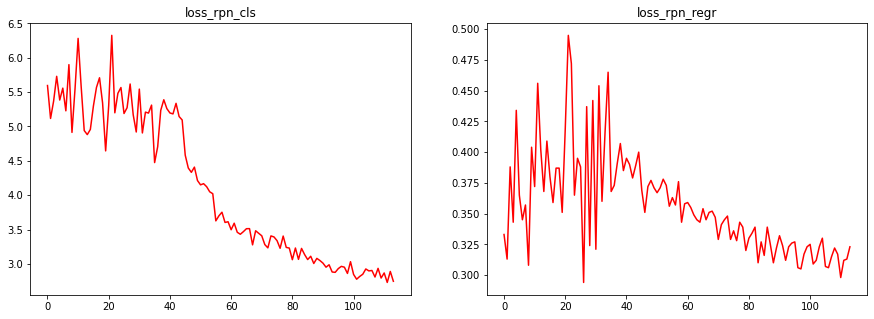

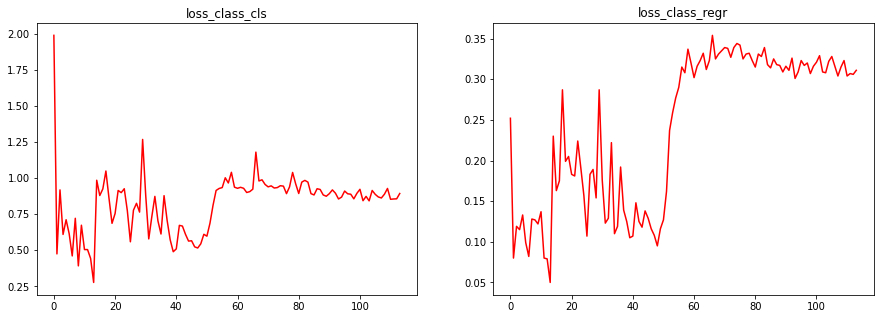

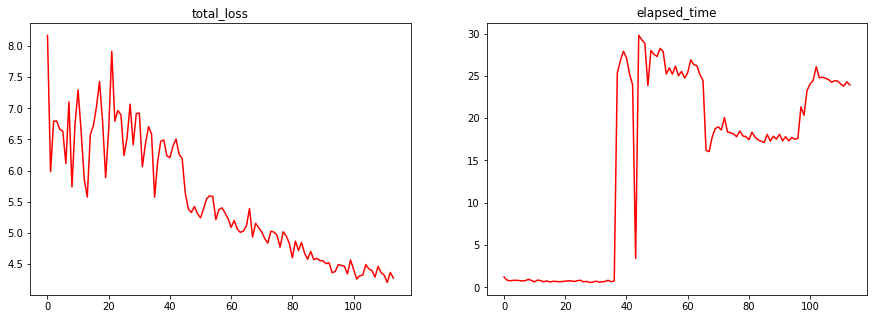

In [ ]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

## Test

In [ ]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [ ]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from /content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/model/model_frcnn_vgg.hdf5


In [ ]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Cardiomegaly', 1: 'Aortic enlargement', 2: 'Pleural thickening', 3: 'Pleural effusion', 4: 'Pulmonary fibrosis', 5: 'Other lesion', 6: 'Nodule/Mass', 7: 'ILD', 8: 'Lung Opacity', 9: 'Infiltration', 10: 'Consolidation', 11: 'Calcification', 12: 'Atelectasis', 13: 'Pneumothorax', 14: 'bg'}


In [ ]:
test_imgs = os.listdir(test_base_path)

imgs_path = []
for i in range(len(test_imgs)):
	# idx = np.random.randint(len(test_imgs))
	# imgs_path.append(test_imgs[idx])
	imgs_path.append(test_imgs[i])

all_imgs = []

classes = {}

In [ ]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    # R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)
    # changed
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])), 4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,2,4)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 1, textOrg[1]+baseLine - 1), (textOrg[0]+retval[0] + 1, textOrg[1]-retval[1] - 1), (0, 0, 0), 2)
            cv2.rectangle(img, (textOrg[0] - 1,textOrg[1]+baseLine - 1), (textOrg[0]+retval[0] + 1, textOrg[1]-retval[1] - 1), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 2, (0, 0, 0), 4)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    # plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

    ##### save image #####
    saved_path = base_path + "/data/detection_test/" + img_name
    cv2.imwrite(saved_path, img)
    ######################

Save prediction on csv file

In [ ]:
# mapping className to class Id
mapping = {
    'Aortic enlargement': 0,
    'Atelectasis': 1,
    'Calcification': 2,
    'Cardiomegaly': 3,
    'Consolidation': 4,
    'ILD': 5,
    'Infiltration': 6,
    'Lung Opacity': 7,
    'Nodule/Mass': 8,
    'Other lesion': 9,
    'Pleural effusion': 10,
    'Pleural thickening': 11,
    'Pneumothorax': 12,
    'Pulmonary fibrosis': 13,
    'No finding': 14
}

In [ ]:
done_df = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission.csv')
done_list = list(done_df['image_id'].unique())
len(done_list)

1262

In [ ]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.85

count = 0
preds = []
for idx, img_name in enumerate(imgs_path):
  if img_name[:-4] not in done_list:
    
    count += 1
    print('%s/1738' % count)

    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    # R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)
    # changed
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    ##############
    # print('bboxes = ', bboxes)
    # print('len of bboxes = ', len(bboxes))
    if len(bboxes) == 0:
      pred = (img_name[:-4], "14 1 0 0 1 1")
      preds.append(pred)
    ##############
    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            ############
            # print('x1 = ', real_x1)
            # print('y1 = ', real_y1)
            # print('x2 = ', real_x2)
            # print('y2 = ', real_y2)
            # print('prob = ', new_probs[jk])
            ############


            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,2,4)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 1, textOrg[1]+baseLine - 1), (textOrg[0]+retval[0] + 1, textOrg[1]-retval[1] - 1), (0, 0, 0), 2)
            cv2.rectangle(img, (textOrg[0] - 1,textOrg[1]+baseLine - 1), (textOrg[0]+retval[0] + 1, textOrg[1]-retval[1] - 1), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 2, (0, 0, 0), 4)

            ################
            print('label = ', key)
            predictionString = str(mapping[key]) + " " + str(round(new_probs[jk], 2)) + \
            " " + str(real_x1) + " " + str(real_y1) + " " + str(real_x2) + " " + str(real_y2)
            pred = (img_name[:-4], predictionString)
            preds.append(pred)
            print(predictionString)
            ################

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    # plt.figure(figsize=(10,10))
    # plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    # plt.show()

    ##### save image #####
    # saved_path = base_path + "/data/detection_test/" + img_name
    # cv2.imwrite(saved_path, img)
    ######################

print(preds)

Streaming output truncated to the last 5000 lines.
173a25467a671ab8f44a8c1e9e02d5e1.png
Elapsed time = 3.874345302581787
[]
1056/1738
17520d7b23b5a393d697ecf139b736fc.png
label =  Pleural thickening
11 0.9 617 231 694 308
Elapsed time = 3.6313555240631104
[('Pleural thickening', 90.4689610004425)]
1057/1738
1782aa7185480390105391366e207a8d.png
label =  Pleural thickening
11 0.89 1381 243 1706 325
label =  Pleural thickening
11 0.88 1625 243 1869 325
label =  Pleural thickening
11 0.85 1625 162 1788 243
Elapsed time = 3.3817570209503174
[('Pleural thickening', 88.73428106307983), ('Pleural thickening', 87.5373125076294), ('Pleural thickening', 85.33473014831543)]
1058/1738
17566869460d2082f1436ffc837f0c2a.png
label =  Cardiomegaly
3 0.96 731 1157 1523 1462
Elapsed time = 3.495344638824463
[('Cardiomegaly', 96.21378779411316)]
1059/1738
17cb989569ca6ef46e1066b0cec22304.png
label =  Cardiomegaly
3 0.88 747 1345 1794 1719
Elapsed time = 3.482842206954956
[('Cardiomegaly', 88.17694783210754

In [ ]:
preds

[('da48002e9656b3ae99cf7cad5fef4d33', '3 0.99 867 1446 1807 1807'),
 ('da48002e9656b3ae99cf7cad5fef4d33', '11 0.89 1374 289 1663 361'),
 ('da7cdc23c69b13c2677e7bf8de1a06e7', '3 0.97 1049 1311 2185 1748'),
 ('da89d223c87e21b2a7d4a1930541177c', '3 0.94 769 1258 1817 1608'),
 ('daac34be8b6ca54b0ab1be81733c0d34', '11 0.92 589 368 811 442'),
 ('daac34be8b6ca54b0ab1be81733c0d34', '11 0.9 1400 442 1622 516'),
 ('daac34be8b6ca54b0ab1be81733c0d34', '11 0.89 442 368 663 442'),
 ('da9d4494e91eedba860f6ad44139a591', '3 0.97 811 1401 1770 1770'),
 ('dae4ebcbbfa68430713520a26a19343c', '11 0.93 1487 247 1818 330'),
 ('dae4ebcbbfa68430713520a26a19343c', '11 0.93 495 330 826 413'),
 ('dae4ebcbbfa68430713520a26a19343c', '11 0.91 1735 330 1818 413'),
 ('dae4ebcbbfa68430713520a26a19343c', '11 0.86 165 1405 247 1487'),
 ('dae4ebcbbfa68430713520a26a19343c', '11 0.86 165 1487 247 1570'),
 ('dad0ade8390ad4e53a98a69bf94ea288', '3 0.99 906 1284 1964 1662'),
 ('db01060306d1f3eb3ea7c1beb8be6edf', '11 0.89 1276 19

In [ ]:
len(preds)

3220

In [ ]:
done_list = [x[0] for x in preds]

In [ ]:
# preds = []
for filename in os.listdir('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/data/test'):
  if filename[:-4] not in done_list:
    preds0.append((filename[:-4], '14 1 0 0 1 1'))

In [ ]:
preds_ = preds[:2278]

In [ ]:
df = pd.DataFrame(preds, columns=['image_id', 'PredictionString'])

In [ ]:
df = df.groupby('image_id')['PredictionString'].apply(lambda x: "%s" % ' '.join(x))

In [ ]:
df = pd.DataFrame(df)

In [ ]:
df.insert(loc=0, column='image_id', value=df.index)

In [ ]:
df

,image_id,PredictionString
image_id,,
002a34c58c5b758217ed1f584ccbcfe9,002a34c58c5b758217ed1f584ccbcfe9,3 0.99 900 1200 1951 1575
004f33259ee4aef671c2b95d54e4be68,004f33259ee4aef671c2b95d54e4be68,3 0.99 966 1449 2013 1771 0 0.89 1288 563 1530...
008bdde2af2462e86fd373a445d0f4cd,008bdde2af2462e86fd373a445d0f4cd,3 0.99 1105 1400 2064 1769 11 0.86 958 442 110...
009bc039326338823ca3aa84381f17f1,009bc039326338823ca3aa84381f17f1,11 0.94 1276 255 1467 319 3 0.98 701 1020 1595...
00a2145de1886cb9eb88869c85d74080,00a2145de1886cb9eb88869c85d74080,3 0.99 888 1298 1845 1640
...,...,...
b38be7898a845062393e06bb52cefc2d,b38be7898a845062393e06bb52cefc2d,3 1.0 829 1403 1659 1722
b39c13808b09d93117fa755e6f8e64ab,b39c13808b09d93117fa755e6f8e64ab,3 0.98 638 1276 1339 1531 11 0.86 382 255 638 ...
b3b085d09a42cfd9d885f4abd7948b03,b3b085d09a42cfd9d885f4abd7948b03,3 0.87 701 1403 1531 1722 11 0.93 446 319 701 ...


In [ ]:
done_list = list(df['image_id'].unique())

In [ ]:
df.to_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission_b.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission.csv')

In [ ]:
done_list = list(df['image_id'].unique())

In [ ]:
li = []
for filename in os.listdir('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/data/test'):
  if filename[:-4] not in done_list:
    li.append((filename[:-4], '14 1 0 0 1 1'))

In [ ]:
df = pd.DataFrame(li, columns=['image_id', 'PredictionString'])
df = df.groupby('image_id')['PredictionString'].apply(lambda x: "%s" % ' '.join(x))
df = pd.DataFrame(df)
df.insert(loc=0, column='image_id', value=df.index)

In [ ]:
df.to_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission_.csv', index=False)

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission.csv')
df2 = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission_.csv')

In [ ]:
 df = pd.concat([df1, df2])

In [ ]:
df.to_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission2.csv', index=False)

In [ ]:
# check 3 csv files
df = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission.csv')
df

,image_id,PredictionString
0,8c7341b62afed8980c0cfa1659909be3,3 0.96 747 1121 1719 1495
1,8cdb33b248a22754d1c2d8b409695a23,11 0.92 737 327 983 409 11 0.92 1967 327 2049 ...
2,8d14c321b87595be89926a9b5219150b,3 0.95 907 1284 1965 1662
3,8d1cee8994769d8a74512426fb45cd98,3 0.92 993 1655 2069 2069 11 0.87 745 331 1076...
4,8d320a31edbc7f28ea0e329c5a91c55c,11 0.93 894 243 975 325 11 0.91 812 325 894 40...
...,...,...
1257,ff91fb82429a27521bbec8569b041f02,11 0.96 1769 294 2064 393 11 0.94 1966 294 226...
1258,ff9fcc4087ed5e941209aa3fa948e364,3 0.93 737 1327 1695 1695 11 0.87 663 368 884 ...
1259,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1
1260,ffc441e0c8b7153844047483a577e7c3,3 0.93 808 1306 1617 1617


In [ ]:
# merge 2 prediction files into 1
df1 = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission.csv')
df2 = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission_b.csv')

df = pd.concat([df1, df2])

df.to_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission_3.csv', index=False)

------------------------------------

In [83]:
# just keep Aortic enlargement (0) and Cardiomegaly (3)
df = pd.read_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission_3.csv')

In [84]:
df

,image_id,PredictionString
0,8c7341b62afed8980c0cfa1659909be3,3 0.96 747 1121 1719 1495
1,8cdb33b248a22754d1c2d8b409695a23,11 0.92 737 327 983 409 11 0.92 1967 327 2049 ...
2,8d14c321b87595be89926a9b5219150b,3 0.95 907 1284 1965 1662
3,8d1cee8994769d8a74512426fb45cd98,3 0.92 993 1655 2069 2069 11 0.87 745 331 1076...
4,8d320a31edbc7f28ea0e329c5a91c55c,11 0.93 894 243 975 325 11 0.91 812 325 894 40...
...,...,...
2995,b38be7898a845062393e06bb52cefc2d,3 1.0 829 1403 1659 1722
2996,b39c13808b09d93117fa755e6f8e64ab,3 0.98 638 1276 1339 1531 11 0.86 382 255 638 ...
2997,b3b085d09a42cfd9d885f4abd7948b03,3 0.87 701 1403 1531 1722 11 0.93 446 319 701 ...
2998,b3bde408c437a5395134a3126fc88060,11 0.92 1966 294 2260 393 11 0.9 1081 294 1376...


In [85]:
pred_list = list(df['PredictionString'])
pred_list

['3 0.96 747 1121 1719 1495',
 '11 0.92 737 327 983 409 11 0.92 1967 327 2049 409 11 0.89 737 245 983 327 11 0.86 901 245 1147 327 11 0.86 1885 327 1967 409',
 '3 0.95 907 1284 1965 1662',
 '3 0.92 993 1655 2069 2069 11 0.87 745 331 1076 413 11 0.86 662 496 745 579',
 '11 0.93 894 243 975 325 11 0.91 812 325 894 406 11 0.9 812 243 894 325 11 0.89 1544 243 1788 325 11 0.88 894 162 1137 243 3 0.98 975 1381 2031 1788',
 '11 0.94 523 523 747 598 11 0.85 598 448 897 523',
 '3 1.0 829 1339 1659 1595 10 0.88 255 1531 382 1659',
 '11 0.91 1867 294 2162 393 11 0.9 1867 393 2162 491 11 0.9 983 393 1277 491',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '11 0.94 1081 393 1376 491 11 0.93 1966 294 2260 393 11 0.88 1966 393 2260 491 11 0.86 1179 294 1474 393 3 0.95 1376 1572 2359 1966',
 '14 1 0 0 1 1',
 '3 0.9 1056 1344 2304 1824',
 '11 0.93 845 507 1099 591 3 0.94 1014 1859 2029 2282',
 '3 0.94 1022 1363 2215 1789',
 '11 0.89 638 191 829 255 11 0.88 638 255 701 319 11 0.87 701 255 893 319',
 '3 0.94 1121 1

In [86]:
li0 = [x.split(" ") for x in pred_list]
li0

[['3', '0.96', '747', '1121', '1719', '1495'],
 ['11',
  '0.92',
  '737',
  '327',
  '983',
  '409',
  '11',
  '0.92',
  '1967',
  '327',
  '2049',
  '409',
  '11',
  '0.89',
  '737',
  '245',
  '983',
  '327',
  '11',
  '0.86',
  '901',
  '245',
  '1147',
  '327',
  '11',
  '0.86',
  '1885',
  '327',
  '1967',
  '409'],
 ['3', '0.95', '907', '1284', '1965', '1662'],
 ['3',
  '0.92',
  '993',
  '1655',
  '2069',
  '2069',
  '11',
  '0.87',
  '745',
  '331',
  '1076',
  '413',
  '11',
  '0.86',
  '662',
  '496',
  '745',
  '579'],
 ['11',
  '0.93',
  '894',
  '243',
  '975',
  '325',
  '11',
  '0.91',
  '812',
  '325',
  '894',
  '406',
  '11',
  '0.9',
  '812',
  '243',
  '894',
  '325',
  '11',
  '0.89',
  '1544',
  '243',
  '1788',
  '325',
  '11',
  '0.88',
  '894',
  '162',
  '1137',
  '243',
  '3',
  '0.98',
  '975',
  '1381',
  '2031',
  '1788'],
 ['11',
  '0.94',
  '523',
  '523',
  '747',
  '598',
  '11',
  '0.85',
  '598',
  '448',
  '897',
  '523'],
 ['3',
  '1.0',
  '829',
 

In [87]:
# function to get sublist of 6
def get_sublist(li):
  n = len(li)
  if n == 6:
    return [li]
  else:
    k = n//6
    new_li = []
    for i in range(k):
      new_li.append(li[i*6: (i+1)*6])
    return new_li

In [88]:
# function to filter: just get 1 or 3 class and proba > 90%
def filter(li):
  new_li = []
  for x in li:
    prob = float(x[1])
    if (x[0] == '3' or x[0] == '14') and prob > 0.99:
      new_li.append(x)
  return new_li

In [89]:
# add no finding 
def add_no_finding(li):
  if len(li) == 0:
    return [['14', '1', '0', '0', '1', '1']]
  else:
    return li

In [90]:
# return a string from a list
def toString(li):
  s = ""
  for i in range(len(li)):
    for j in range(6):
      if (i == len(li) - 1) and (j == 5):
        s += li[i][j]
      else:
        s += li[i][j] + " "
  return s 

In [91]:
li1 = [get_sublist(x) for x in li0]
li1

[[['3', '0.96', '747', '1121', '1719', '1495']],
 [['11', '0.92', '737', '327', '983', '409'],
  ['11', '0.92', '1967', '327', '2049', '409'],
  ['11', '0.89', '737', '245', '983', '327'],
  ['11', '0.86', '901', '245', '1147', '327'],
  ['11', '0.86', '1885', '327', '1967', '409']],
 [['3', '0.95', '907', '1284', '1965', '1662']],
 [['3', '0.92', '993', '1655', '2069', '2069'],
  ['11', '0.87', '745', '331', '1076', '413'],
  ['11', '0.86', '662', '496', '745', '579']],
 [['11', '0.93', '894', '243', '975', '325'],
  ['11', '0.91', '812', '325', '894', '406'],
  ['11', '0.9', '812', '243', '894', '325'],
  ['11', '0.89', '1544', '243', '1788', '325'],
  ['11', '0.88', '894', '162', '1137', '243'],
  ['3', '0.98', '975', '1381', '2031', '1788']],
 [['11', '0.94', '523', '523', '747', '598'],
  ['11', '0.85', '598', '448', '897', '523']],
 [['3', '1.0', '829', '1339', '1659', '1595'],
  ['10', '0.88', '255', '1531', '382', '1659']],
 [['11', '0.91', '1867', '294', '2162', '393'],
  ['11

In [92]:
li2 = [filter(x) for x in li1]
li2

[[],
 [],
 [],
 [],
 [],
 [],
 [['3', '1.0', '829', '1339', '1659', '1595']],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [],
 [],
 [],
 [],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [['3', '1.0', '829', '1403', '1786', '1722']],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [['3', '1.0', '829', '1339', '1722', '1659']],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['3', '1.0', '967', '1693', '2016', '2096']],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [],
 [['14', '1', '0', '0', '1', '1']],
 [['3', '1.0', '940', '1566', '2115', '1958']],
 [['14', '1', '0', '0', '1', '1']],
 [['3', '1.0', '638', '1339', '1339', '1595']],
 [],
 [],
 []

In [93]:
li3 = [add_no_finding(x) for x in li2]
li3

[[['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['3', '1.0', '829', '1339', '1659', '1595']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0', '0', '1', '1']],
 [['14', '1', '0

In [94]:
li4 = [toString(x) for x in li3]
li4

['14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '3 1.0 829 1339 1659 1595',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '3 1.0 829 1403 1786 1722',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '3 1.0 829 1339 1722 1659',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '3 1.0 967 1693 2016 2096',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',
 '14 1 0 0 1 1',


In [95]:
len(li4)

3000

In [96]:
df = df.drop(['PredictionString'], axis=1)

In [97]:
df

,image_id
0,8c7341b62afed8980c0cfa1659909be3
1,8cdb33b248a22754d1c2d8b409695a23
2,8d14c321b87595be89926a9b5219150b
3,8d1cee8994769d8a74512426fb45cd98
4,8d320a31edbc7f28ea0e329c5a91c55c
...,...
2995,b38be7898a845062393e06bb52cefc2d
2996,b39c13808b09d93117fa755e6f8e64ab
2997,b3b085d09a42cfd9d885f4abd7948b03
2998,b3bde408c437a5395134a3126fc88060


In [98]:
df['PredictionString'] = li4

In [99]:
df

,image_id,PredictionString
0,8c7341b62afed8980c0cfa1659909be3,14 1 0 0 1 1
1,8cdb33b248a22754d1c2d8b409695a23,14 1 0 0 1 1
2,8d14c321b87595be89926a9b5219150b,14 1 0 0 1 1
3,8d1cee8994769d8a74512426fb45cd98,14 1 0 0 1 1
4,8d320a31edbc7f28ea0e329c5a91c55c,14 1 0 0 1 1
...,...,...
2995,b38be7898a845062393e06bb52cefc2d,3 1.0 829 1403 1659 1722
2996,b39c13808b09d93117fa755e6f8e64ab,14 1 0 0 1 1
2997,b3b085d09a42cfd9d885f4abd7948b03,14 1 0 0 1 1
2998,b3bde408c437a5395134a3126fc88060,14 1 0 0 1 1


In [100]:
df.to_csv('/content/drive/My Drive/AI PROJECTS/Kaggle/VinBigData Chest X-Ray/submission_7.csv', index=False)